In [1]:
%cd ..

/home/feodor/Jupyter/depth-poset


/home/feodor/Jupyter/jupyter-env/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import itertools
import inspect
import time

import numpy as np
import pandas as pd
import gudhi as gh
import networkx as nx

from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

from src import depth
from src.depth import DepthPoset
from src.drow import plot_filtred_complex2d, plot_simplex, enumerate_points

from tqdm import tqdm

# The Simplicial Complex

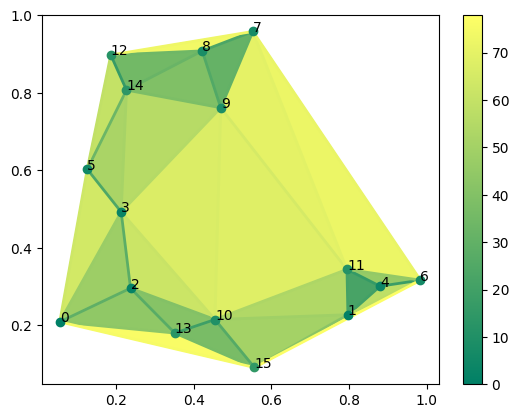

In [3]:
n, dim = 16, 2
points = np.random.random([n, dim])

stree = gh.AlphaComplex(points).create_simplex_tree()
simplices = [simplex for simplex, value in stree.get_filtration()]
filtration_values = np.asarray([value for simplex, value in stree.get_filtration()])
new_filtration_values = np.argsort(filtration_values)
for simplex, value in zip(simplices, new_filtration_values):
    stree.assign_filtration(simplex, value)

sm = plot_filtred_complex2d(stree, points, cmap='summer')
plt.colorbar(sm, ax=plt.gca())
enumerate_points(points)

# Define and iterate the Transpositions

In [4]:
def order_is_possible(order):
    # returns False if there are bigger simplices before the smallest
    for i0 in range(len(order)):
        for i1 in range(i0 + 1, len(order)):
            s0 = np.sort(order[i0])
            s1 = np.sort(order[i1])
            intersection = np.intersect1d(s0, s1)
            if list(s1) == list(intersection):
                return False
    return True

In [5]:
def iterate_possible_transpositions_indices(order, neighbours=True):
    # 
    if neighbours:
        generator = np.transpose([np.arange(len(order) - 1), np.arange(len(order) - 1) + 1])
    else:
        generator = itertools.combinations(range(len(order)), 2)
    for i0, i1 in generator:
        new_order = order.copy()
        new_order[i0], new_order[i1] = new_order[i1], new_order[i0]
        if order_is_possible(new_order):
            yield i0, i1

In [6]:
def get_transposition_type(stree: gh.SimplexTree, s0, s1):
    """
    Returns the type of the transpositon (birth-birth, death-deat, birth-death, another) of 2 simplices: s0 and s1
    """
    s0, s1 = tuple(np.sort(s0)), tuple(np.sort(s1))
    try:
        pairs = stree.persistence_pairs()
    except AssertionError:
        stree.compute_persistence()
        pairs = stree.persistence_pairs() 
    births = [tuple(np.sort(pair[0])) for pair in pairs]
    deaths = [tuple(np.sort(pair[1])) for pair in pairs]
    if s0 in births and s1 in births:
        return 'birth-birth'
    if s0 in deaths and s1 in deaths:
        return 'death-death'
    if s0 in births and s1 in deaths:
        return 'birth-death'
    if s0 in deaths and s1 in births:
        return 'birth-death'

In [7]:
def iterate_possible_transpositions(stree: gh.SimplexTree, neighbours=True, transposition_type=None):
    # 
    order = [simplex for simplex, value in stree.get_filtration()]
    for i0, i1 in iterate_possible_transpositions_indices(order, neighbours=neighbours):
        transposition = {'index 0': i0, 
                         'index 1': i1, 
                         'value 0': stree.filtration(order[i0]), 
                         'value 1': stree.filtration(order[i1]), 
                         'simplex 0': order[i0], 
                         'simplex 1': order[i1], 
                         'dim 0': len(order[i0]) - 1, 
                         'dim 1': len(order[i1]) - 1, 
                         'type': get_transposition_type(stree, order[i0], order[i1]), 
                        }
        if (transposition_type is None) or (transposition_type == transposition['type']):
            yield transposition

In [8]:
timer = time.perf_counter()
df_transpositions = pd.DataFrame(iterate_possible_transpositions(stree))
timer = time.perf_counter() - timer

print(f'Transpositions are found in {timer:.4f} seconds.\n')
print(f'Transposition types distribution:\n{
        '\n'.join(str(df_transpositions['type'].value_counts()).split('\n')[1:-1])
        }\n')

print(f'df_transpositions.shape = {df_transpositions.shape}')
df_transpositions.head()

Transpositions are found in 4.2015 seconds.

Transposition types distribution:
birth-death    24
birth-birth    16
death-death    15

df_transpositions.shape = (55, 9)


,index 0,index 1,value 0,value 1,simplex 0,simplex 1,dim 0,dim 1,type
0,0,1,0.0,1.0,[0],[1],0,0,birth-birth
1,1,2,1.0,2.0,[1],[2],0,0,birth-birth
2,2,3,2.0,3.0,[2],[3],0,0,birth-birth
3,3,4,3.0,4.0,[3],[4],0,0,birth-birth
4,4,5,4.0,5.0,[4],[5],0,0,birth-birth


## Plot the Transposition

In [9]:
def plot_transposition(transposition, stree0, stree1, dp0, dp1, fig=None, axs=None, figsize=(9, 8), cmap='summer'):
    # returns fig, axs
    s0 = transposition['simplex 0']
    s1 = transposition['simplex 1']

    if fig is None or axs is None:
        fig, axs = plt.subplots(2, 2, figsize=figsize)
    
    fig.suptitle(f'The {transposition['type'].replace('b', 'B').replace('d', 'D')} Transposition of Simplices {s0} and {s1}')
    axs[0, 0].set_title('Complex before the Transposition')
    axs[0, 1].set_title('Complex after the Transposition')
    axs[1, 0].set_title('Depth Poset before the Transposition')
    axs[1, 1].set_title('Depth Poset after the Transposition')
    
    
    for i, streei in enumerate([stree0, stree1]):
        sm = plot_filtred_complex2d(streei, points, ax=axs[0, i], cmap=cmap, linewidth=4)
        plt.colorbar(sm, ax=axs[0, i])
    
        plot_simplex(s0, points, ax=axs[0, i], color='red', marker='x', linestyle=':', hatch='+', 
                 label=f'f({s0}) = {streei.filtration(s0)}', zorder=4)
        plot_simplex(s1, points, ax=axs[0, i], color='blue', marker='x', linestyle=':', hatch='+', 
                 label=f'f({s1}) = {streei.filtration(s1)}', zorder=4)
        enumerate_points(points, ax=axs[0, i])
        axs[0, i].legend()
    
    for i, dpi in enumerate([dp0, dp1]):
        node_color = ['gold' if tuple(s0) in node.source or tuple(s1) in node.source else 'teal' for node in dpi.nodes]
        nx.draw_networkx(dpi.get_transitive_reduction(), pos=dpi.persistant_layout(), ax=axs[1, i], 
                         node_color=node_color, node_size=36, 
                         labels=dpi.get_labels(), 
                         with_labels=False, hide_ticks=False)
        axs[1, i].fill_between([0, max(dpi.get_filtration_values())], 
                               [0, max(dpi.get_filtration_values())], [0, 0], color='lightgrey')
        axs[1, i].set_xlim(*(max(dpi.get_filtration_values())*np.array([-0.05, 1.05])))
        axs[1, i].set_ylim(*(max(dpi.get_filtration_values())*np.array([-0.05, 1.05])))

    return fig, axs

In [10]:
def get_strees(transposition, stree: gh.SimplexTree):
    # returns 2 SimplexTrees, before and after the transposition
    s0, s1 = transposition['simplex 0'], transposition['simplex 1']
    v0, v1 = transposition['value 0'], transposition['value 1']
    stree0 = stree.copy()
    stree1 = stree.copy()
    stree1.assign_filtration(s1, v0)
    stree1.assign_filtration(s0, v1)
    return stree0, stree1

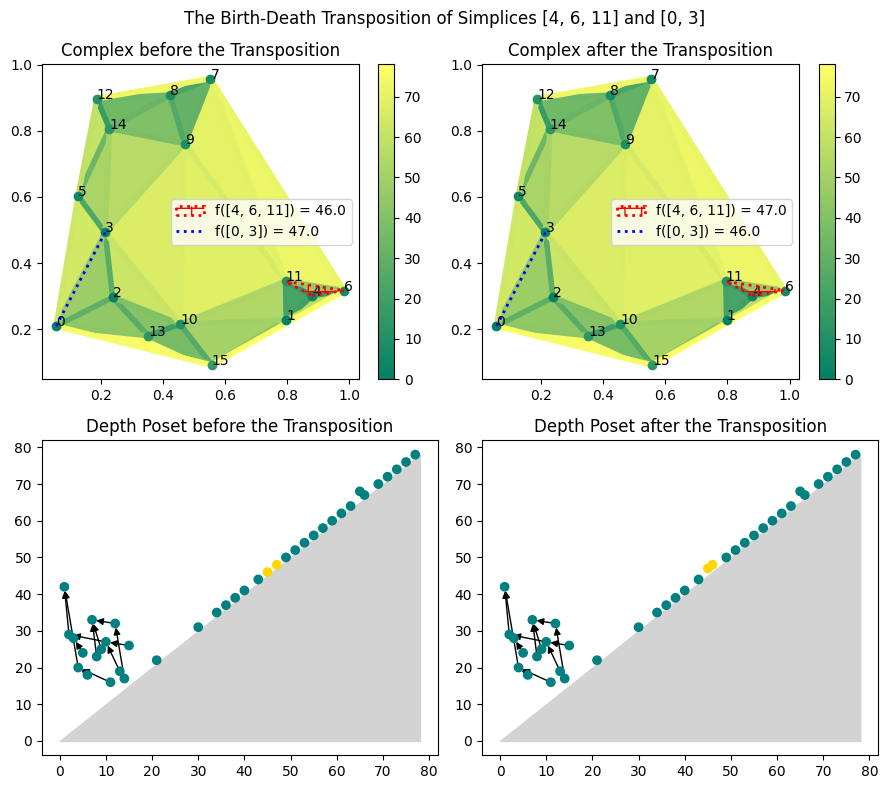

In [11]:
transposition = df_transpositions.loc[np.random.choice(df_transpositions.index)]

stree0, stree1 = get_strees(transposition, stree)

dp0 = DepthPoset.from_simplex_tree(stree0)
dp1 = DepthPoset.from_simplex_tree(stree1)

fig, axs = plot_transposition(transposition, stree0, stree1, dp0, dp1)
plt.tight_layout()
plt.show()

## Classifying the Transpositions

In [12]:
def get_xyab_bb(transposition, dp0: DepthPoset):
    # Returns x, y, a, b indices for birth-birth case
    if transposition['type'] != 'birth-birth':
        return None
    for node in dp0.nodes:
        if node.birth_index == transposition['index 0']:
            x = node.birth_index
            y = node.death_index
        if node.birth_index == transposition['index 1']:
            a = node.birth_index
            b = node.death_index
    return x, y, a, b

def get_xyab_dd(transposition, dp0: DepthPoset):
    # Returns x, y, a, b indices for death-death case
    if transposition['type'] != 'death-death':
        return None
    for node in dp0.nodes:
        if node.death_index == transposition['index 0']:
            x = node.birth_index
            y = node.death_index
        if node.death_index == transposition['index 1']:
            a = node.birth_index
            b = node.death_index
    return x, y, a, b

def get_xyab_bd(transposition, dp0: DepthPoset):
    # Returns x, y, a, b indices for birth-death case
    if transposition['type'] != 'birth-death':
        return None
    for node in dp0.nodes:
        if node.death_index == transposition['index 0']:
            a = node.birth_index
            b = node.death_index
        if node.death_index == transposition['index 1']:
            a = node.birth_index
            b = node.death_index
        if node.birth_index == transposition['index 0']:
            x = node.birth_index
            y = node.death_index
        if node.birth_index == transposition['index 1']:
            x = node.birth_index
            y = node.death_index
    return x, y, a, b
    
def get_xyab(transposition, dp0: DepthPoset):
    # 
    try:
        if transposition['type'] == 'birth-birth':
            return get_xyab_bb(transposition, dp0)
        if transposition['type'] == 'death-death':
            return get_xyab_dd(transposition, dp0)
        if transposition['type'] == 'birth-death':
            return get_xyab_bd(transposition, dp0)
    except UnboundLocalError:
        return None

In [13]:
df_transpositions['xyab'] = [get_xyab(transposition, dp0) for i, transposition in df_transpositions.iterrows()]

assert df_transpositions['xyab'].isna().sum() == 1

print(f'df_transpositions.shape = {df_transpositions.shape}')
df_transpositions.head()

df_transpositions.shape = (55, 10)


,index 0,index 1,value 0,value 1,simplex 0,simplex 1,dim 0,dim 1,type,xyab
0,0,1,0.0,1.0,[0],[1],0,0,birth-birth,None
1,1,2,1.0,2.0,[1],[2],0,0,birth-birth,"(1, 42, 2, 29)"
2,2,3,2.0,3.0,[2],[3],0,0,birth-birth,"(2, 29, 3, 28)"
3,3,4,3.0,4.0,[3],[4],0,0,birth-birth,"(3, 28, 4, 20)"
4,4,5,4.0,5.0,[4],[5],0,0,birth-birth,"(4, 20, 5, 24)"


In [14]:
def get_transposition_relations_and_classifying_matrix(stree0, dp0, transposition):
    # 
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    try:
        x, y, a, b = get_xyab(transposition, dp0)
    except TypeError:
        return None, None, None

    stop_condition = lambda alpha, b0, delta: len({(a, b), (a, y), (x, b), (x, y)} & set(alpha.values())) + \
                                              len({(a, x), (x, a), (b, y), (y, b)} & set(b0)) > 0
    if transposition['type'] == 'birth-birth':
        #stop_condition = lambda alpha, b0, delta0: len({(a, b), (a, y), (x, b), (x, y)} & set(alpha.values())) + len({(b, y), (y, b)} & set (b0)) != 0
        alpha, b0, delta0 = depth.reduct_column_bottom_to_top(border_matrix0, stop_condition)
        return list(alpha.values()), b0, tuple(map(tuple, delta0[np.sort([x, a])][:, np.sort([y, b])]))
    if transposition['type'] == 'death-death':
        #stop_condition = lambda omega, b1, delta1: len({(a, b), (a, y), (x, b), (x, y)} & set(omega.values())) + len({(a, x), (x, a)} & set (b1)) != 0
        omega, b1, delta1 = depth.reduct_row_left_to_right(border_matrix0, stop_condition)
        return list(omega.values()), b1, tuple(map(tuple, delta1[np.sort([x, a])][:, np.sort([y, b])]))
    if transposition['type'] == 'birth-death':
        #stop_condition = lambda alpha, b0, delta0: len({(a, b), (a, y), (x, b), (x, y)} & set(alpha.values())) + len({(b, y), (y, b)} & set (b0)) != 0
        alpha, b0, delta0 = depth.reduct_column_bottom_to_top(border_matrix0, stop_condition)
        #stop_condition = lambda omega, b1, delta1: len({(a, b), (a, y), (x, b), (x, y)} & set(omega.values())) + len({(a, x), (x, a)} & set (b1)) != 0
        omega, b1, delta1 = depth.reduct_row_left_to_right(delta0, stop_condition)
        return list(alpha.values()) + list(omega.values()), b0 + b1, tuple(map(tuple, delta1[np.sort([a, b, x, y])][:, np.sort([a, b, x, y])]))
        

In [15]:
(df_transpositions['bd-pairs'], 
 df_transpositions['relations'], 
 df_transpositions['classifying matrix']) = zip(*[get_transposition_relations_and_classifying_matrix(stree0, dp0, transposition) for i, transposition in df_transpositions.iterrows()])


assert df_transpositions['relations'].isna().sum() == 1
assert df_transpositions['classifying matrix'].isna().sum() == 1

print(f'df_transpositions.shape = {df_transpositions.shape}')
df_transpositions.head()

df_transpositions.shape = (55, 13)


,index 0,index 1,value 0,value 1,simplex 0,simplex 1,dim 0,dim 1,type,xyab,bd-pairs,relations,classifying matrix
0,0,1,0.0,1.0,[0],[1],0,0,birth-birth,None,None,None,None
1,1,2,1.0,2.0,[1],[2],0,0,birth-birth,"(1, 42, 2, 29)","[(77, 78), (75, 76), (73, 74), (71, 72), (69, ...","[(67, 68), (26, 42), (17, 32), (17, 33), (19, ...","((0, 1), (1, 1))"
2,2,3,2.0,3.0,[2],[3],0,0,birth-birth,"(2, 29, 3, 28)","[(77, 78), (75, 76), (73, 74), (71, 72), (69, ...","[(67, 68), (26, 42), (17, 32), (17, 33), (19, ...","((1, 1), (1, 0))"
3,3,4,3.0,4.0,[3],[4],0,0,birth-birth,"(3, 28, 4, 20)","[(77, 78), (75, 76), (73, 74), (71, 72), (69, ...","[(67, 68), (26, 42), (17, 32), (17, 33), (19, ...","((0, 1), (1, 0))"
4,4,5,4.0,5.0,[4],[5],0,0,birth-birth,"(4, 20, 5, 24)","[(77, 78), (75, 76), (73, 74), (71, 72), (69, ...","[(67, 68), (26, 42), (17, 32), (17, 33), (19, ...","((1, 0), (0, 1))"


In [16]:
def get_switch_type(stree0, dp0, transposition):
    # 
    matrix = get_transposition_relations_and_classifying_matrix(stree0, dp0, transposition)

    if transposition['type'] == 'birth-birth':
        if matrix == ((1, 1), 
                      (1, 0)):
            return "switch forward"
        if matrix == ((1, 0), 
                      (1, 1)):
            return "switch backward"
    if transposition['type'] == 'death-death':
        if matrix == ((0, 1), 
                      (1, 1)):
            return "switch forward"
        if matrix == ((1, 0), 
                      (1, 1)):
            return "switch backward"
    if transposition['type'] == 'birth-death':
        if matrix == ((0, 1, 1, 0), 
                      (0, 0, 0, 1), 
                      (0, 0, 0, 1), 
                      (0, 0, 0, 0)):
            return "switch forward"
    return 'no switch'

In [17]:
df_transpositions['switch'] = df_transpositions.apply(lambda row: get_switch_type(stree0, dp0, row), axis=1)

df_transpositions['switch'].value_counts()

switch
no switch    55
Name: count, dtype: int64

In [18]:
expected_classifying_matrices = {
    'birth-birth': [((1, 1), 
                     (1, 0)), 
                    ((1, 0), 
                     (1, 1)), 
                    ((0, 1), 
                     (1, 1)), 
                    ((1, 1), 
                     (0, 1)), 
                    ((0, 1), 
                     (1, 0)), 
                    ((1, 0), 
                     (0, 1)),
                    None, 
                   ], 
    'death-death': [((0, 1), 
                     (1, 1)), 
                    ((1, 0), 
                     (1, 1)), 
                    ((1, 1), 
                     (1, 0)), 
                    ((1, 1), 
                     (0, 1)), 
                    ((0, 1), 
                     (1, 0)), 
                    ((1, 0), 
                     (0, 1)), 
                   ],
    'birth-death': [((0, 1, 1, 0), 
                     (0, 0, 0, 1), 
                     (0, 0, 0, 1), 
                     (0, 0, 0, 0)), 
                    ((0, 1, 0, 0), 
                     (0, 0, 0, 0), 
                     (0, 0, 0, 1), 
                     (0, 0, 0, 0)), 
                    ((0, 0, 1, 0), 
                     (0, 0, 0, 1), 
                     (0, 0, 0, 0), 
                     (0, 0, 0, 0)), 
                   ]
}

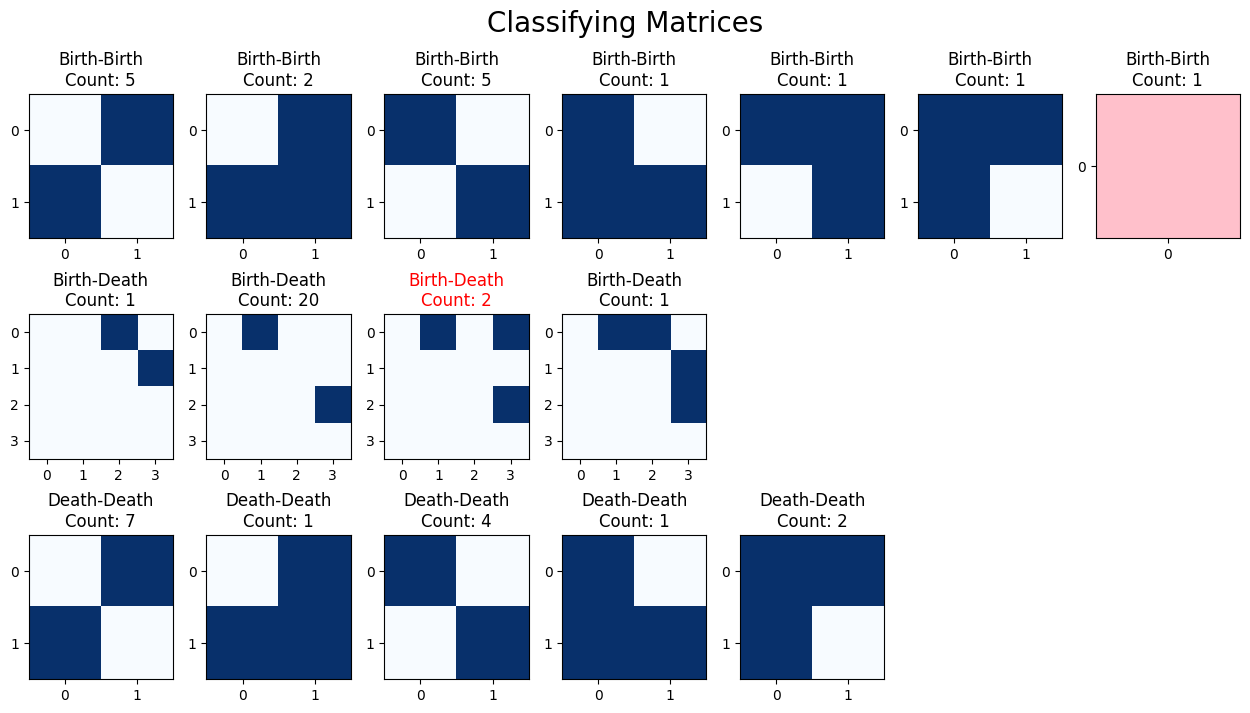

In [19]:
situations = df_transpositions[['type', 'classifying matrix', 'xyab']].fillna('None').rename(columns={'xyab': 'count'})
situations = situations.groupby(['type', 'classifying matrix'], as_index=False).count().replace('None', None)

situations['expected'] = situations.apply(lambda row: row['classifying matrix'] in expected_classifying_matrices[row['type']], axis=1)


n = situations['type'].value_counts().max()
m = len(pd.unique(situations['type']))
fig, axs = plt.subplots(m, n, figsize=(1.8*n, 2.4*m))
fig.suptitle('Classifying Matrices', fontsize=20)

cmap = plt.get_cmap('Blues')
cmap.set_bad(color='pink')

for j, situation_type in enumerate(pd.unique(situations['type'])):
    these_situations = situations[situations['type'] == situation_type].reset_index(drop=True)
    for i, situation in these_situations.iterrows():
        matrix = these_situations.loc[i, 'classifying matrix']
        if matrix is None:
            matrix = np.nan*np.ones([1, 1])
        matrix = np.array(matrix)
        axs[j, i].set_title(f'{situation_type.replace('b', 'B').replace('d', 'D')}\nCount: {situation['count']}', 
                            color='black' if situation['expected'] else 'red')
        axs[j, i].imshow(matrix, cmap=cmap, vmin=0, vmax=1, origin='upper')
        axs[j, i].set_xticks(np.arange(matrix.shape[1]))
        axs[j, i].set_yticks(np.arange(matrix.shape[0]))
    for i in range(len(these_situations), n):
        axs[j, i].set_xticks([])
        axs[j, i].set_yticks([])
        for spine in axs[j, i].spines.values():
            spine.set_visible(False)

plt.tight_layout()
plt.show()

In [20]:
df_transpositions['expected'] = df_transpositions.apply(lambda row: row['classifying matrix'] in expected_classifying_matrices[row['type']], axis=1)

print(f"There are {(~df_transpositions['expected']).sum()} unexpected situations.")


There are 2 unexpected situations.


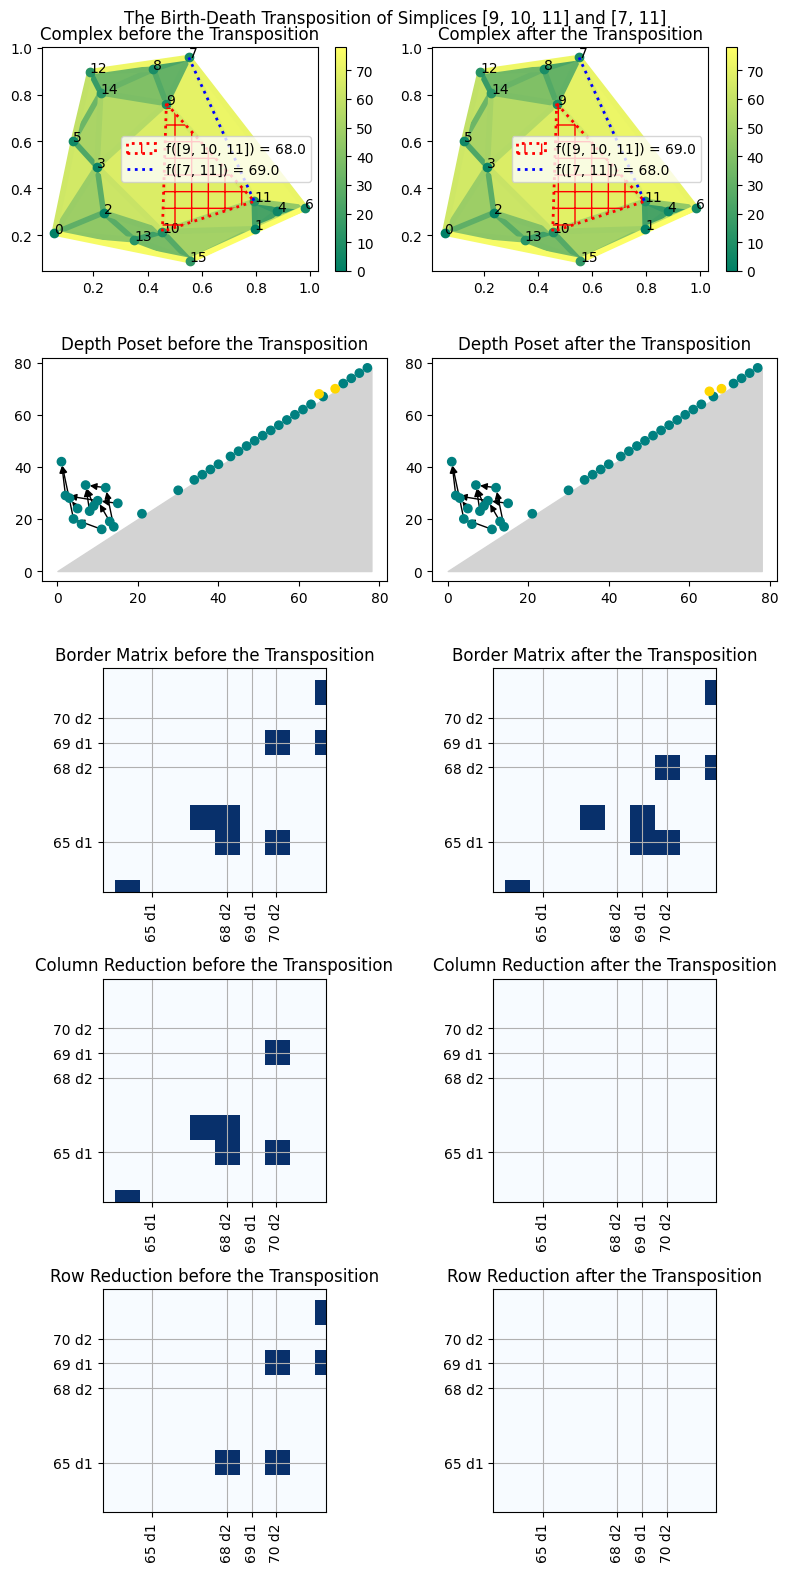

In [21]:
drow_more = True

for i, transposition in df_transpositions[~df_transpositions['expected']].iterrows():
    stree0, stree1 = get_strees(transposition, stree)

    dp0 = DepthPoset.from_simplex_tree(stree0)
    dp1 = DepthPoset.from_simplex_tree(stree1)

    fig, axs = plt.subplots(5, 2, figsize=(8, 16))
    fig, axs = plot_transposition(transposition, stree0, stree1, dp0, dp1, fig=fig, axs=axs)

    x, y, a, b = get_xyab(transposition, dp0)
    assert (np.sort([x, y, a, b]) == np.sort(get_xyab(transposition, dp1))).all()
    
    lim_min = np.min([x, y, a, b]) - 2
    lim_max = np.max([x, y, a, b]) + 3
    extents = [(lim_min, lim_min), 
               (lim_min, lim_max), 
               (lim_max, lim_min), 
               (lim_max, lim_max), 
              ]

    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    order1, border_matrix1 = depth.get_ordered_border_matrix_from_simplex_tree(stree1)

    axs[2, 0].set_title('Border Matrix before the Transposition')
    axs[2, 1].set_title('Border Matrix after the Transposition')
    axs[2, 0].imshow(border_matrix0, cmap='Blues', origin='upper')
    axs[2, 1].imshow(border_matrix1, cmap='Blues', origin='upper')
    
    stop_condition = lambda alpha, b0, delta: len({(a, b), (a, y), (x, b), (x, y)} & set(alpha.values())) + \
                                              len({(a, x), (x, a), (b, y), (y, b)} & set(b0)) > 0
    alpha0, b00, delta00 = depth.reduct_column_bottom_to_top(border_matrix0, stop_condition)
    alpha1, b01, delta01 = depth.reduct_column_bottom_to_top(border_matrix1, stop_condition)

    axs[3, 0].set_title('Column Reduction before the Transposition')
    axs[3, 1].set_title('Column Reduction after the Transposition')
    axs[3, 0].imshow(delta00, cmap='Blues', origin='upper')
    axs[3, 1].imshow(delta01, cmap='Blues', origin='upper')
    
    omega0, b10, delta10 = depth.reduct_row_left_to_right(border_matrix0, stop_condition)
    omega1, b11, delta11 = depth.reduct_row_left_to_right(border_matrix1, stop_condition)

    axs[4, 0].set_title('Row Reduction before the Transposition')
    axs[4, 1].set_title('Row Reduction after the Transposition')
    axs[4, 0].imshow(delta10, cmap='Blues', origin='upper')
    axs[4, 1].imshow(delta11, cmap='Blues', origin='upper')

    ticks = np.sort([x, y, a, b])
    for j2 in [2, 3, 4]:
        axs[j2, 0].set_xticks(ticks, labels=[f'{tick} d{len(order0[tick]) - 1}' for tick in ticks], rotation=90)
        axs[j2, 0].set_yticks(ticks, labels=[f'{tick} d{len(order0[tick]) - 1}' for tick in ticks], rotation=0)
        axs[j2, 1].set_xticks(ticks, labels=[f'{tick} d{len(order0[tick]) - 1}' for tick in ticks], rotation=90)
        axs[j2, 1].set_yticks(ticks, labels=[f'{tick} d{len(order0[tick]) - 1}' for tick in ticks], rotation=0)
        for j in range(2):
            axs[j2, j].set_xlim(lim_min, lim_max - 1)
            axs[j2, j].set_ylim(lim_min, lim_max - 1)
            axs[j2, j].grid(True)

    plt.tight_layout()
    plt.savefig(f'pics/unexpected_transposition-{i}.png')

    # Show an example only once
    if drow_more:
        plt.show()
        drow_more = False
    else:
        plt.close()

# Basic Set Difference Measures

In [22]:
def jacard_index(a, b):
    """
    Calculate the Jaccard index
    """
    intersection = set(a) & set(b)
    union = set(a) | set(b)
    if len(union) == 0:
        return 1
    return len(intersection) / len(union)

# Lemmas and Hypothesises

Write $\text{Succ}(s, t) = \text{Succ}'(s, t) = \text{Succ}''(s, t)$ for the succesors and $\text{Pred}(s, t) = \text{Pred}'(s, t) = \text{Pred}''(s, t)$ for the predecessors (ancessors) of the pair in $D$, $D'$, $D''$, respectively.

Since $D = D' \cup D''$, we also have $\text{Succ}(s, t) = \text{Succ}'(s, t) \cup \text{Succ}''(s, t)$ and $\text{Pred}(s, t) = \text{Pred}'(s, t) \cup \text{Pred}''(s, t)$.

## Lemma 3.1.
Suppose $(x, y)$ and $(a, b)$ are birth-death pairs of $f: X\to R$, $a, x$ are consecutive in the ordering of the cellls by $f$, and the transposition $a, x$ is a switch. Then
$$
\text{Succ}'(a, y) = \{(x, b)\} \cup \text{Succ}'(a, b) \cup \{(s, t)\in \text{Succ}'(x, y) | f(t)<f(b)\}
$$
$$
\text{Succ}'(x, b) = \{(s, t)\in \text{Succ}'(x, y) | f(t) > f(b)\}
$$


In [23]:
transposition = df_transpositions.loc[np.random.choice(df_transpositions[df_transpositions['type'] == 'birth-birth'].index)]

stree0, stree1 = get_strees(transposition, stree)

dp0 = DepthPoset.from_simplex_tree(stree0)
dp1 = DepthPoset.from_simplex_tree(stree1)

transposition

index 0                                                              65
index 1                                                              66
value 0                                                            65.0
value 1                                                            66.0
simplex 0                                                       [9, 11]
simplex 1                                                       [9, 10]
dim 0                                                                 1
dim 1                                                                 1
type                                                        birth-birth
xyab                                                   (65, 68, 66, 67)
bd-pairs              [(77, 78), (75, 76), (73, 74), (71, 72), (69, ...
relations                                                    [(67, 68)]
classifying matrix                                     ((0, 1), (1, 1))
switch                                                        no